# **Self-Supervision is All You Need for Solving Rubik's Cube**

**Date created:** 2022/01/27<br>
**Last modified:** 2022/08/13<br>

---
## **Description**

This notebook is intended to demonstrate the proposed method and to allow for reproducible experiments.

For the purpose of demonstration, the number of training steps is set to $10000$ and the beam width is set to $2^{12}$ by default.
If you want to replicate our best reported result, set ```TrainConfig.num_train_steps``` to $1000000$ and ```top_k``` to $2^{18}$. Note, however, that it will take several days to finish both training and inference.

## **Training & Inference**

The DNN is trained to predict the last move of a scramble based on the corresponding problem state. In inference, the inverse of the predicted last move is applied to the given state.

## **Test**

The trained model is evaluated on [1,000 test cases provided by Forest Agostinelli, et al. (2019)](https://github.com/forestagostinelli/DeepCubeA/) and compared to the result of DeepCubeA and an optimal solver in three respects: a) solution lengths, b) number of nodes, and c) computation time.

---
### ***Q. How much time does this notebook take?***

For reference, with one 4-core CPU and one GPU ([NVIDIA Tesla P100 PCIe 16GB](https://images.nvidia.com/content/tesla/pdf/nvidia-tesla-p100-PCIe-datasheet.pdf)), it took **about 3 hours** to run the entire notebook, including training, inference, and comparison.

## Setup

Parameters

In [1]:
# problem
METRIC = "QTM"
SCRAMBLE_LENGTH = {"QTM": 26, "HTM": 20}[METRIC]
# training
class TrainConfig:
    learning_rate = 1e-3
    batch_size_per_depth = 1000
    num_train_steps = 1000000
    interval_steps_save = 1000
    interval_steps_plot = 100
    scramble_length = SCRAMBLE_LENGTH

# inference
## The wider the beam search, the more time required, but the shorter the solution.
top_k = 2**10
## This can be any number greater than or equal to the Gods Number.
max_depth = SCRAMBLE_LENGTH * 2


Modules

In [2]:
#@title
import time
import random
import pickle
import numpy as np
import multiprocessing
from copy import deepcopy
from tqdm import tqdm, trange
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'multiprocessing.cpu_count(): {multiprocessing.cpu_count()}')
!nvidia-smi -L


device: cpu
multiprocessing.cpu_count(): 8


"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113Visualization functions

In [3]:
#@title
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(
    color=["#212121", "#2180FE", "#EB4275"])


def plt_history(h):
    fig, axes = plt.subplots(1, 1, figsize=[4, 4])
    axes.plot(h)
    axes.set_xscale("log")
    axes.set_title("Loss")
    plt.show()


def regression_coef(x, y):
    coef = np.array(y) / np.array(x)
    coef = np.mean(np.squeeze(coef))
    return coef


def plot_result(solutions_all, num_nodes_all, times_all):
    fig, ax = plt.subplots(2, 3, figsize=(16, 9))
    ax = ax.ravel()
    for i, result in enumerate([solutions_all, num_nodes_all, times_all]):
        result = [e for e in result if e is not None]
        if i == 0:  # soltions
            result = [len(e) for e in result if e is not None]
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            result = {i: result.count(i)
                      for i in range(min(result), max(result) + 1)}
            ax[i].bar(
                result.keys(),
                result.values(),
                width=1.0,
                label=f"Success: {len([len(e) for e in solutions_all if e is not None])}/{len(solutions_all)}",
            )
            ax[i].legend()
            ax[i].set_xlabel("Solution length")
            ax[i].set_ylabel("Frequency")
        else:
            ax[i].hist(result)
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            ax[i].legend()
            if i == 1:
                ax[i].set_xlabel("No. of nodes")
            else:
                ax[i].set_xlabel("Calculation time (s)")

    solution_lengths, num_nodes, times = [
        [e for e in result if e is not None]
        for result in [solutions_all, num_nodes_all, times_all]
    ]
    solution_lengths = [len(e) for e in solution_lengths]

    for (xlabel, ylabel), (x, y) in [
        [("Solution lengths", "No. of nodes"), (solution_lengths, num_nodes)],
        [("No. of nodes", "Calculation time (s)"), (num_nodes, times)],
        [("Calculation time (s)", "Solution lengths"), (times, solution_lengths)],
    ]:
        i += 1
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        x_range = np.linspace(0, max(x), 100)
        ax[i].plot(
            x_range,
            x_range * regression_coef(x, y),
            label=f"slope={round(regression_coef(x, y), 5)}",
            color="#00ffff",
        )
        ax[i].scatter(x, y)
        ax[i].legend()

    plt.show()


## Rubik's Cube
Rubik's Cube is operated based on the locations and colors of 6$\times$9 stickers.

We employ [Quarter-Turn Metric](https://www.speedsolving.com/wiki/index.php/Metric#QTM) (90° turns count as one move; 180°, two) for both scrambling and solving the puzzle.


In [4]:
import random
import numpy as np


class Cube(object):
    """
    A class for 3x3x3 Rubik's Cube
    """
    def __init__(self, metric=METRIC):
        self.DTYPE = np.int64
        self.metric = metric

        # define state and goal
        self.reset()  # state
        self.goal = np.arange(0, 9 * 6, dtype=self.DTYPE) // 9

        # define moves
        ## faces and turns
        faces = ["U", "D", "L", "R", "B", "F"]
        ## [90 degrees clockwise, 90 degrees counter-clockwise]
        degrees = ["", "'"]
        degrees_inference = degrees[::-1]
        if self.metric == "HTM":
            # += [180 degrees]
            degrees += ["2"]
            degrees_inference += ["2"]
        else:
            assert self.metric == "QTM"
        self.moves = [f"{f}{n}" for f in faces for n in degrees]
        self.moves_inference = [f"{f}{n}" for f in faces for n in degrees_inference]

        # opposite faces
        self.pairing = {
            "R": "L",
            "L": "R",
            "F": "B",
            "B": "F",
            "U": "D",
            "D": "U",
        }
        # prohibit obviously reduntant moves. 
        if self.metric == "HTM":
            # two subsequent moves on the same face (cancelling or redundant).
            self.moves_available_after = {
                m: [v for v in self.moves if v[0] != m[0]] for m in self.moves
            }
        elif self.metric == "QTM":
            # self-cancelling moves on the same face
            self.moves_available_after = {
                m: [v for v in self.moves if v[0] != m[0]] + [m] for m in self.moves
            }
        else:
            raise

        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.arange(0, 9 * 6, dtype=self.DTYPE) // 9

    def is_solved(self):
        return np.all(self.state == self.goal)

    def state_to_batch(self):
        return np.expand_dims(self.state, axis=0)

    def finger(self, move):
        self.state[self.sticker_target[move]] = self.state[self.sticker_source[move]]

    def scrambler(self, scramble_length):
        """
        A generator function yielding the state and scramble
        """
        while True:
            # reset the self.state, scramble, and retun self.state and scramble moves
            self.reset()
            scramble = []

            for i in range(scramble_length):
                if i:
                    last_move = scramble[-1]
                    if i > 1:  # N(>=3)th moves
                        while True:
                            move = random.choice(self.moves_available_after[last_move])
                            if self.metric == "QTM":
                                if scramble[-2] == last_move == move:
                                    # Two mutually canceling moves in a row
                                    continue
                                elif (
                                    scramble[-2][0] == move[0]
                                    and len(scramble[-2] + move) == 3
                                    and last_move[0] == self.pairing[move[0]]
                                ):
                                    # Two mutually canceling moves sandwiching an opposite face move
                                    continue
                                else:
                                    break
                            elif self.metric == "HTM":
                                if scramble[-2][0] == move[0] and last_move[0] == self.pairing[move[0]]:
                                    # Two mutually canceling moves sandwiching an opposite face move
                                    continue
                                else:
                                    break
                            else:
                                raise
                    else:  # 2nd move
                        move = random.choice(self.moves_available_after[last_move])
                else:  # 1st move
                    move = random.choice(self.moves)

                self.finger(move)
                scramble.append(move)

                yield self.state, move
                
    def sequence(self, move_list):
        for move in move_list:
            self.finger(move)

    def __vectorize_moves(self):
        """
        This method defines ```self.sticker_target``` and ```self.sticker_source``` to manage sticker colors (target is replaced by source).
        They define indices of target and source stickers so that the moves can be vectorized.

        colors:
                0 0 0
                0 0 0
                0 0 0
            2 2 2 5 5 5 3 3 3 4 4 4
            2 2 2 5 5 5 3 3 3 4 4 4
            2 2 2 5 5 5 3 3 3 4 4 4
                1 1 1
                1 1 1
                1 1 1
        order of stickers on each face:
             2  5  8
             1  4  7
            [0] 3  6

        indices of state (each starting with 9*(n-1)):
                         2   5   8
                         1   4   7
                        [0]  3   6
             20  23 26  47  50  53  29  32 35  38  41 44
             19  22 25  46  49  52  28  31 34  37  40 43
            [18] 21 24 [45] 48  51 [27] 30 33 [36] 39 42
                        11   14 17
                        10   13 16
                        [9]  12 15
        """
        self.sticker_target, self.sticker_source = dict(), dict()

        self.sticker_replacement = {
            # Sticker A is replaced by another sticker at index B -> A:B
            "U": {
                0: 6,
                1: 3,
                2: 0,
                3: 7,
                5: 1,
                6: 8,
                7: 5,
                8: 2,
                20: 47,
                23: 50,
                26: 53,
                29: 38,
                32: 41,
                35: 44,
                38: 20,
                41: 23,
                44: 26,
                47: 29,
                50: 32,
                53: 35,
            },
            "D": {
                9: 15,
                10: 12,
                11: 9,
                12: 16,
                14: 10,
                15: 17,
                16: 14,
                17: 11,
                18: 36,
                21: 39,
                24: 42,
                27: 45,
                30: 48,
                33: 51,
                36: 27,
                39: 30,
                42: 33,
                45: 18,
                48: 21,
                51: 24,
            },
            "L": {
                0: 44,
                1: 43,
                2: 42,
                9: 45,
                10: 46,
                11: 47,
                18: 24,
                19: 21,
                20: 18,
                21: 25,
                23: 19,
                24: 26,
                25: 23,
                26: 20,
                42: 11,
                43: 10,
                44: 9,
                45: 0,
                46: 1,
                47: 2,
            },
            "R": {
                6: 51,
                7: 52,
                8: 53,
                15: 38,
                16: 37,
                17: 36,
                27: 33,
                28: 30,
                29: 27,
                30: 34,
                32: 28,
                33: 35,
                34: 32,
                35: 29,
                36: 8,
                37: 7,
                38: 6,
                51: 15,
                52: 16,
                53: 17,
            },
            "B": {
                2: 35,
                5: 34,
                8: 33,
                9: 20,
                12: 19,
                15: 18,
                18: 2,
                19: 5,
                20: 8,
                33: 9,
                34: 12,
                35: 15,
                36: 42,
                37: 39,
                38: 36,
                39: 43,
                41: 37,
                42: 44,
                43: 41,
                44: 38,
            },
            "F": {
                0: 24,
                3: 25,
                6: 26,
                11: 27,
                14: 28,
                17: 29,
                24: 17,
                25: 14,
                26: 11,
                27: 6,
                28: 3,
                29: 0,
                45: 51,
                46: 48,
                47: 45,
                48: 52,
                50: 46,
                51: 53,
                52: 50,
                53: 47,
            },
        }
        for m in self.moves:
            if len(m) == 1:
                assert m in self.sticker_replacement
            else:
                if "'" in m:
                    self.sticker_replacement[m] = {
                        v: k for k, v in self.sticker_replacement[m[0]].items()
                    }
                elif "2" in m:
                    self.sticker_replacement[m] = {
                        k: self.sticker_replacement[m[0]][v]
                        for k, v in self.sticker_replacement[m[0]].items()
                    }
                else:
                    raise

            self.sticker_target[m] = list(self.sticker_replacement[m].keys())
            self.sticker_source[m] = list(self.sticker_replacement[m].values())

            for i, idx in enumerate(self.sticker_target[m]):
                assert self.sticker_replacement[m][idx] == self.sticker_source[m][i]


cube = Cube()

## Model

In [5]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.linearblock_1 = LinearBlock(embed_dim, embed_dim)
        self.linearblock_2 = LinearBlock(embed_dim, embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.linearblock_1(x)
        x = self.linearblock_2(x)
        x += inputs # skip-connection
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.one_hot = nn.functional.one_hot
        self.Stack = nn.Sequential(
            LinearBlock(324, 5000),
            LinearBlock(5000, 1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
        )
        self.Prediction = nn.Linear(1000, len(cube.moves))

    def forward(self, inputs):
        x = inputs
        x = self.one_hot(x.to(torch.int64), num_classes=6).to(torch.float).reshape(-1, 324)
        x = self.Stack(x)
        logits = self.Prediction(x)
        return logits


model = Model().to(device)


## Training

In [6]:
def batch_generator(
        batch_size_per_depth,
        scramble_length=SCRAMBLE_LENGTH,
        n_jobs=multiprocessing.cpu_count(),
    ):
    # setup
    __dtype = np.int64
    batch_size = batch_size_per_depth * scramble_length
    # multiprocessing
    cubes = [Cube()] * n_jobs
    generators = [c.scrambler(scramble_length=scramble_length) for c in cubes]

    global get_minibatch

    def get_minibatch(i):
        states = np.zeros((scramble_length, 9 * 6), dtype=__dtype)
        last_moves = np.zeros((scramble_length,), dtype=__dtype)
        g_local = generators[i % n_jobs]
        for j in range(scramble_length):
            _, last_move = next(g_local)
            states[j, :] = cubes[i % n_jobs].state  # _to_numpy()
            last_moves[j] = cube.moves.index(last_move)

        return states, last_moves

    # create the Pool instance after ```defining cubes``` and ```get_minibatch```
    p = multiprocessing.Pool(n_jobs)
    for _ in iter(int, 1):
        ret = p.map(get_minibatch, list(range(batch_size_per_depth)))
        batch_x = np.concatenate([e[0] for e in ret])
        batch_y = np.concatenate([e[1] for e in ret], axis=0)
        yield (batch_x, batch_y)

In [7]:
import pandas as pd
import numpy as np

C:\Users\andri\AppData\Local\Temp\ipykernel_8772\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
pd.set_option('display.max_columns', 500)

In [9]:
batch_generator(
        batch_size_per_depth=TrainConfig.batch_size_per_depth,
        scramble_length=TrainConfig.scramble_length,
    )

<generator object batch_generator at 0x000001CB7B5EDFC0>

In [10]:
# input_ = next(batch_generator(
#         batch_size_per_depth=TrainConfig.batch_size_per_depth,
#         scramble_length=TrainConfig.scramble_length,
#     ))

In [11]:
model.to('cpu')

Model(
  (Stack): Sequential(
    (0): LinearBlock(
      (fc): Linear(in_features=324, out_features=5000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (linearblock_1): LinearBlock(
        (fc): Linear(in_features=1000, out_features=1000, bias=True)
        (relu): ReLU()
        (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (linearblock_2): LinearBlock(
        (fc): Linear(in_features=1000, out_features=1000, bias=True)
        (relu): ReLU()
        (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ResidualBlock(
      (linearblock_1): LinearBloc

In [12]:
#torch.from_numpy(input_[0][0:5000]).size()

In [13]:
#model(torch.from_numpy(input_[0][0:2]))

In [14]:
def train(config):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    BATCH_SIZE = config.batch_size_per_depth * config.scramble_length
    scramble_length = config.scramble_length
    g = batch_generator(
        batch_size_per_depth=config.batch_size_per_depth,
        scramble_length=config.scramble_length,
    )
    h = []

    for i in trange(1, config.num_train_steps + 1, smoothing=0):
        # prep
        batch_x, batch_y = next(g)
        batch_x, batch_y = torch.from_numpy(batch_x).to(device), torch.from_numpy(
            batch_y
        ).to(device)

        # update
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if config.interval_steps_plot and i % config.interval_steps_plot == 0:
            clear_output()
            plt_history(h)
        if config.interval_steps_save and i % config.interval_steps_save == 0:
            torch.save(model.state_dict(), f"{METRIC}-model_{i}steps.pth")
            print("Model saved.")

In [15]:
cube.reset()

In [16]:
cube.state

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

In [17]:
# train(TrainConfig)
# print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_train_steps} solves.")


In [18]:
model.load_state_dict(torch.load('QTM-model_1000000steps.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
model.to(device)

Model(
  (Stack): Sequential(
    (0): LinearBlock(
      (fc): Linear(in_features=324, out_features=5000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (linearblock_1): LinearBlock(
        (fc): Linear(in_features=1000, out_features=1000, bias=True)
        (relu): ReLU()
        (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (linearblock_2): LinearBlock(
        (fc): Linear(in_features=1000, out_features=1000, bias=True)
        (relu): ReLU()
        (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ResidualBlock(
      (linearblock_1): LinearBloc

## Inference

We test and compare on the DeepCubeA dataset

In [20]:
%%capture
model.eval()

### Dataset

Download dataset from GitHub

In [21]:
# %cd /content/
# !git clone -q https://github.com/forestagostinelli/DeepCubeA
# %cd /content/DeepCubeA/
# import 


# print('### Optimal Solver ###')
# filename = 'data/cube3/test/data_0.pkl'
# with open(filename, 'rb') as f:
#     if 'states' in filename:
#         data_Optimal = pickle.load(f, encoding='iso-8859-1')
#     else:
#         data_Optimal = pickle.load(f)

# print(data_Optimal.keys())
# solutions_Optimal, times_Optimal, num_nodes_Optimal = [
#     data_Optimal[e] for e in ['solutions', 'times', 'num_nodes_generated']]
# len_Optimal = [len(s) for s in solutions_Optimal]
# len_Optimal_count = {i: len_Optimal.count(
#     i) for i in range(min(len_Optimal), max(len_Optimal))}

# print('No. of cases:', len(len_Optimal))

# print('\n### Optimal Solver ###')

# filename = 'results/cube3/results.pkl'
# with open(filename, 'rb') as f:
#     if 'states' in filename:
#         data_DeepCubeA = pickle.load(f, encoding='iso-8859-1')
#     else:
#         data_DeepCubeA = pickle.load(f)

# print(data_DeepCubeA.keys())
# solutions_DeepCubeA, times_DeepCubeA, num_nodes_DeepCubeA = [
#     data_DeepCubeA[e] for e in ['solutions', 'times', 'num_nodes_generated']]
# len_DeepCubeA = [len(s) for s in solutions_DeepCubeA]
# len_DeepCubeA_count = {i: len_DeepCubeA.count(
#     i) for i in range(min(len_DeepCubeA), max(len_DeepCubeA))}

# print('No. of cases:', len(solutions_DeepCubeA))

# %cd /content/


Convert optimal solutions to test scrambles

In [22]:
# # scrambles are the inverse of the optimal solutions
# def solution2scramble(solution):
#     return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

# test_scrambles = [solution2scramble(s) for s in solutions_Optimal]

# print(f"""Example: {solutions_Optimal[0]} -> {test_scrambles[0]}""")


### Beam Search

In [23]:
def beam_search(
        cube,
        top_k,
        max_depth,
        skip_redundant_moves=True,
    ):
    """
    Beam search algorithm.
    Input:
        cube: A scrambled Rubik's Cube
        top_k: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
    Output: 
        (move_hist, num_nodes, time_taken): ('first solution found', 'the number of nodes expanded', 'the amount of time')
    """
    with torch.no_grad():
        # metrics
        num_nodes = 0
        time_0 = time.time()
        # manage candidates by their states and path (list of moves} as ordered lists
        candidate_states, candidate_paths = [cube.state], [[]]

        # loop until you find a solution OR you reach the maxium depth.
        for depth in range(max_depth):
            # create a batch of states to to predict for the depth
            if depth==0: # the very initial state:
                batch_x = cube.state_to_batch()
            else: 
                batch_x = np.zeros((len(candidate_paths), 54), dtype=np.int64)
                for i, move_hist in enumerate(candidate_paths):
                    # apply the next predicted move
                    cube.state = candidate_states[i]
                    cube.finger(move_hist[-1])
                    num_nodes += 1
                    if cube.is_solved():
                        time_taken = time.time() - time_0
                        return move_hist, num_nodes, time_taken
                    # else make prediction, adding it to batch_x
                    batch_x[i, :] = deepcopy(cube.state)

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x).to("cpu").detach().numpy()

            # loop over candidate_paths
            potential_candidates = []  # storage for the depth-level candidates storing (path, value, index).
            for i, move_hist in enumerate(candidate_paths):
                prediction_candicate = batch_p[i, :] # output logits for the given state
                for ix in range(len(cube.moves)): # iterate over all possible moves.
                    p = prediction_candicate[ix] # predicted value to expand the path with the given move.
                    m = cube.moves_inference[ix]
                    if move_hist:
                        if skip_redundant_moves:
                            # remove obviously redundant moves.
                            if METRIC == "QTM":
                                if m not in cube.moves_available_after[move_hist[-1]]:
                                    # Two mutually canceling moves
                                    continue
                                elif len(move_hist) == 1:
                                    potential_candidates.append((move_hist+[m], p, i))
                                else:  # len(move_hist)>1
                                    if move_hist[-2] == move_hist[-1] == m:
                                        # three subsequent same moves
                                        continue
                                    elif (
                                        move_hist[-2][0] == m[0]
                                        and len(move_hist[-2] + m) == 3
                                        and move_hist[-1][0] == cube.pairing[m[0]]
                                    ):
                                        # Two mutually canceling moves sandwiching an opposite face move
                                        continue
                                    else:
                                        potential_candidates.append((move_hist+[m], p, i))
                            elif METRIC == "HTM":
                                if m[0] == move_hist[-1][0]:
                                    # Two mutually canceling moves
                                    continue
                                elif len(move_hist) == 1:
                                    potential_candidates.append((move_hist+[m], p, i))
                                else:  # len(move_hist)>1
                                    if move_hist[-2][0] == m[0] and move_hist[-1][0] == cube.pairing[m[0]]:
                                        # Two mutually canceling moves sandwiching an opposite face move
                                        continue
                                    else:
                                        potential_candidates.append((move_hist+[m], p, i))
                            else:
                                raise
                        else: # the 2nd move
                            potential_candidates.append((move_hist+[m], p, i))
                    else:
                        # the 1st move
                        potential_candidates.append(([m], p, i))

            # sort potential paths by expected values
            potential_candidates = sorted(potential_candidates, key=lambda item: -item[1])
            # if the number of candidates exceed that of beam width 'top_k'
            if top_k < len(potential_candidates):
                potential_candidates = potential_candidates[:top_k]

            # renew the candidates
            candidate_paths = [e[0] for e in potential_candidates]
            candidate_states = [deepcopy(candidate_states[e[2]]) for e in potential_candidates]

        # if you reaches the maximum depth, the last expanded nodes are tested.
        for i, move_hist in enumerate(candidate_paths):
            # apply the next predicted move & check if solved.
            cube.state = candidate_states[i]
            cube.finger(move_hist[-1])
            num_nodes += 1
            if cube.is_solved():
                time_taken = time.time() - time_0
                return move_hist, num_nodes, time_taken

        # if you DO NOT find any solution with the given configuration, return None's
        print("Solution not found.")
        return None, None, None

In [30]:
cube.reset(), cube.state

(None,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64))

In [34]:
cube.sequence(["U'","L'", 'D',"U'","L'", 'D',"U'","L'", 'D', 'F']), cube.state

(None,
 array([3, 0, 0, 2, 0, 4, 4, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 0, 2, 0, 2, 5,
        2, 5, 5, 1, 0, 2, 0, 3, 4, 3, 5, 3, 3, 3, 4, 4, 5, 2, 4, 2, 4, 4,
        4, 1, 3, 5, 5, 5, 0, 5, 3, 0]))

In [24]:
cube.reset()

In [29]:
cube.state = np.array([2,5,0,0,0,3,3,4,1,
        0,3,0,0,1,5,2,2,1,
        3,2,5,1,2,0,3,3,1,
        2,4,4,1,3,1,4,4,3,
        0,2,5,2,4,0,4,5,2,
        5,5,5,1,5,4,4,3,1])

In [30]:
result = beam_search(cube, top_k, max_depth)
print(result[0])

["R'", 'B', "F'", "R'", 'D', "R'", "B'", 'U', 'D', 'L', "F'", 'L', 'B', "L'", "D'", 'B', 'R', 'D', 'R', 'U', 'R', 'U', "R'"]


In [37]:
def transformar_letras(cadena):
    # Crear una lista para almacenar los resultados transformados
    nueva_lista = []
    
    # Iterar sobre cada elemento de la lista
    for elemento in cadena:
        # Si el elemento contiene "'", se elimina y se convierte a minúsculas
        if "'" in elemento:
            nuevo_elemento = elemento.replace("'", "").lower()
        else:
            nuevo_elemento = elemento
        # Agregar el elemento transformado a la nueva lista
        nueva_lista.append(nuevo_elemento)
    
    # Concatenar todas las letras en una sola línea
    nueva_cadena = ''.join(nueva_lista)
    
    return nueva_cadena

resultado = transformar_letras(result[0])
print(resultado)



rBfrDrbUDLfLBldBRDRURUr


### Solve

In [36]:
cube.state

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5])

### Conclusion


In [23]:
# solutions_all, num_nodes_all, times_all = [], [], []

# for scramble in tqdm(test_scrambles, position=0):
#     # reset and scramble
#     cube.reset()
#     for scramble_move in scramble:
#         cube.finger(scramble_move)
#     # solve
#     solution, num_nodes, time_taken = beam_search(cube, top_k, max_depth)
#     if num_nodes:
#         solutions_all.append(solution)
#         num_nodes_all.append(num_nodes)
#         times_all.append(time_taken)

# plot_result(solutions_all, num_nodes_all, times_all)


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

## Comparison to DeepCubeA

### Solution length vs No. of nodes

In [ ]:
# num_nodes_ours = [e for e in num_nodes_all if e]
# num_nodes_ours = [e for e in num_nodes_all if e]
# times_ours = [e for e in times_all if e]
# len_ours = [len(e) for e in solutions_all if e]
# len_ours_count = {i: len_ours.count(i) for i in range(min(len_ours), max(len_ours))}


In [1]:
# left, width = 0.12, 0.75
# bottom, height = 0.1, 0.75
# spacing = 0.0

# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height, width, 0.1]
# rect_histy = [left + width, bottom, 0.1, height]

# fig = plt.figure(figsize=(7.5, 7.5))
# ax = fig.add_axes(rect_scatter)
# ax.set_xlabel("Solution length")
# ax.set_ylabel("No. of nodes")
# ax.set_yscale("log")
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)
# ax_histx.set_ylabel("Frequency")
# ax_histy.set_xlabel("Frequency")
# ax_histx.tick_params(axis="x", labelbottom=False)
# ax_histy.tick_params(axis="y", labelleft=False)

# ax.set_xlim(15, max(len_ours))
# ax_histx.set_xlim(15, max(len_ours))

# ymax = 8.25
# ax.set_ylim(10**2.5, 10**ymax)
# ax_histy.set_ylim(10**2.5, 10**ymax)
# bins_x = np.logspace(2.5, ymax, 100)

# for k, (y, x) in {
#         "Optimal": (num_nodes_Optimal, len_Optimal),
#         "DeepCubeA": (num_nodes_DeepCubeA, len_DeepCubeA),
#         "Ours": (num_nodes_ours, len_ours),
#     }.items():
#     ax.scatter(x, y, label=k, s=10)
#     if k == "Optimal":
#         ax_histy.hist(y, bins=bins_x, orientation="horizontal")
#     else:
#         ax_histy.hist(y, bins=bins_x, orientation="horizontal")

# for i, d in enumerate([len_Optimal_count, len_DeepCubeA_count, len_ours_count]):
#     if i:
#         ax_histx.bar(list(d.keys()), list(d.values()), width=1)
#     else:
#         ax_histx.bar(list(d.keys()), list(d.values()), width=1.0)

# ax_histx.axvline(np.mean(len_ours), color="#EB4275")
# ax.axvline(np.mean(len_ours), color="#EB4275")

# ax.plot(np.mean(len_Optimal), np.mean(num_nodes_Optimal), "x", markersize=10)
# ax.plot(np.mean(len_DeepCubeA), np.mean(num_nodes_DeepCubeA), "x", markersize=10)
# ax.plot(np.mean(len_ours), np.mean(num_nodes_ours), "x", label="Ours", markersize=10)
# ax.legend()

# plt.show()


### Calculation time (s) vs. Solution length

We compare time taken to solve test cases. 

In order to compare fairly our method to DeepCubeA, both of which are DNN-based, we obtain per-node time (s) and adjust ours to DeepCubeA.

Optimal:	1.4801182995895741e-06
DeepCubeA:	9.073204353441794e-06
Ours:	9.461254480153633e-05


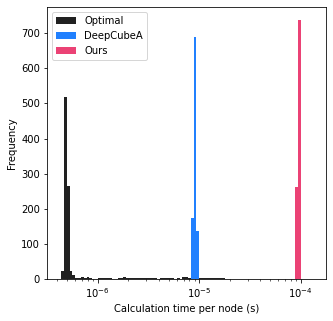

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.set_xlabel("Calculation time per node (s)")
# ax.set_ylabel("Frequency")
# ax.set_xscale("log")
# ax.set_xlim(10**-6.5, 10**-3.75)
# bins_x = np.logspace(-6.5, -3.75, 100)
# for k, (n, t, s) in {
#         "Optimal": (num_nodes_Optimal, times_Optimal, len_Optimal),
#         "DeepCubeA": (num_nodes_DeepCubeA, times_DeepCubeA, len_DeepCubeA),
#         "Ours": (num_nodes_ours, times_ours, len_ours),
#     }.items():
#     time_per_node = np.array(t) / np.array(n)
#     ax.hist(time_per_node, bins=bins_x, label=k)
#     print(f"{k}:\t{np.mean(time_per_node)}")
# ax.legend()
# plt.show()


In [ ]:
# t_per_node_DeepCubeA = np.array(times_DeepCubeA) / np.array(num_nodes_DeepCubeA)
# t_per_node_Ours = np.array(times_ours) / np.array(num_nodes_ours)
# t_ratio = np.mean(t_per_node_Ours) / np.mean(t_per_node_DeepCubeA)
# t_ratio


10.42768807093454

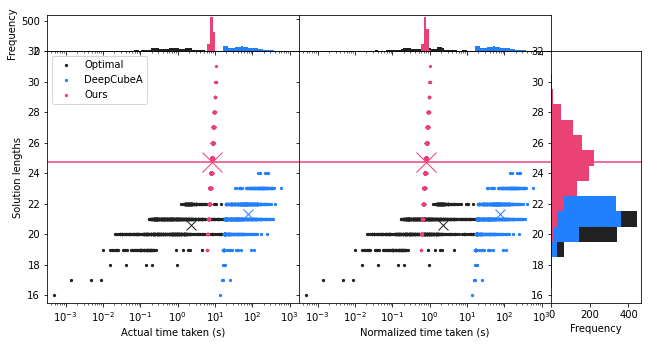

In [ ]:
# left, width = 0.125, 0.35
# bottom, height = 0.135, 0.70

# rect_scatter = [left, bottom, width, height]
# rect_scatter_j = [left + width, bottom, width, height]
# rect_histx_0 = [left, bottom + height, width, 0.10]
# rect_histx_1 = [left + width, bottom + height, width, 0.10]
# rect_histy = [left + 2 * (width), bottom, 0.125, height]

# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_axes(rect_scatter)
# ax.set_xlabel("Actual time taken (s)")
# ax.set_ylabel("Solution lengths")
# ax.set_xscale("log")
# ax_j = fig.add_axes(rect_scatter_j)
# ax_j.set_xlabel("Normalized time taken (s)")
# ax_j.set_xscale("log")
# ax_j.tick_params(axis="y", labelleft=False)

# ax_histx_0 = fig.add_axes(rect_histx_0, sharex=ax)
# ax_histx_0.set_ylabel("Frequency")
# ax_histx_0.tick_params(axis="x", labelbottom=False)
# ax_histx_1 = fig.add_axes(rect_histx_1, sharex=ax)
# ax_histx_1.tick_params(axis="x", labelbottom=False)
# ax_histx_1.tick_params(axis="y", labelleft=False)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)
# ax_histy.set_xlabel("Frequency")
# ax_histy.tick_params(axis="y", labelleft=True)

# bins_x = np.logspace(-3.5, 3.25, 100)
# for k, (t, s) in {
#         "Optimal": (times_Optimal, len_Optimal),
#         "DeepCubeA": (times_DeepCubeA, len_DeepCubeA),
#         "Ours": (times_ours, len_ours),
#     }.items():
#     ax.scatter(t, s, label=k, s=5)
#     if k == "Optimal":
#         ax_histx_0.hist(t, bins=bins_x)
#     else:
#         ax_histx_0.hist(t, bins=bins_x)
#     if k == "Ours":
#         t_just = np.array(t) / t_ratio
#         ax_histx_1.hist(t_just, bins=bins_x)
#         ax_j.scatter(t_just, s, label=k, s=5)
#     else:
#         if k == "Optimal":
#             ax_histx_1.hist(np.array(t), bins=bins_x,)
#         else:
#             ax_histx_1.hist(np.array(t), bins=bins_x)
#         ax_j.scatter(np.array(t), s, label=k, s=5)

# for AX in [ax, ax_j]:
#     AX.plot(np.mean(times_Optimal), np.mean(len_Optimal), "x", markersize=10)
#     AX.plot(np.mean(times_DeepCubeA), np.mean(len_DeepCubeA), "x", markersize=10)
#     AX.set_xlim(10**-3.5, 10**3.25)
#     AX.set_ylim(15.5, max(len_ours) + 1)

# for AX in [ax, ax_j, ax_histy]:
#     AX.axhline(np.mean(len_ours), color="#EB4275")

# for i, d in enumerate([len_Optimal_count, len_DeepCubeA_count, len_ours_count]):
#     if i:
#         ax_histy.barh(list(d.keys()), list(d.values()), height=1)
#     else:
#         ax_histy.barh(list(d.keys()), list(d.values()), height=1)


# ax.plot(np.mean(times_ours), np.mean(len_ours), "x", markersize=20)
# ax_j.plot(np.mean(times_ours) / t_ratio, np.mean(len_ours), "x", markersize=20)

# ax.legend()
# plt.show()
